# **INDIAN PINES**

**XG BOOST**

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.05 minutes


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Computing lacunarity for box size 2...
Computing lacunarity for box size 4...
Computing lacunarity for box size 8...
Computing lacunarity for box size 16...
Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2          0.345297
1         4          0.679886
2         8          0.879651
3        16          0.980196
4        32          0.999152


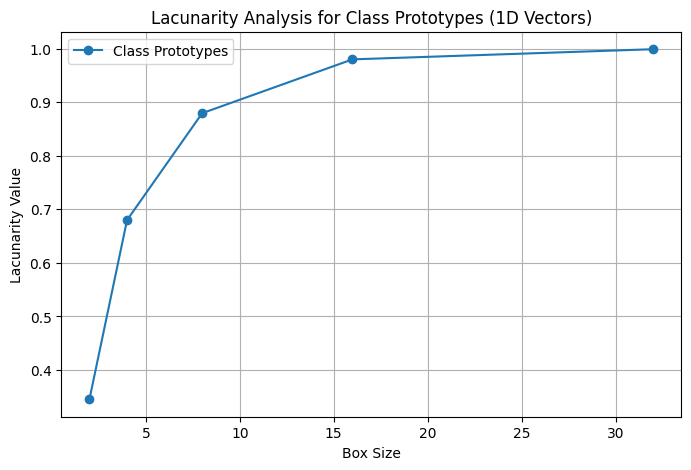

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from sklearn.decomposition import PCA

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train XGBoost Model
# --------------------------------------------
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")
start_time = time.time()
xgb_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Class Prototypes
# --------------------------------------------
X_train_embeddings = xgb_classifier.apply(X_train)

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])


# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Use reasonable box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**ADA BOOST**

Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training Time: 1.26 minutes
Computing lacunarity for box size 2...
Computing lacunarity for box size 4...
Computing lacunarity for box size 8...
Computing lacunarity for box size 16...
Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2          0.006249
1         4          0.009293
2         8          0.011361
3        16          0.013833
4        32          0.016818


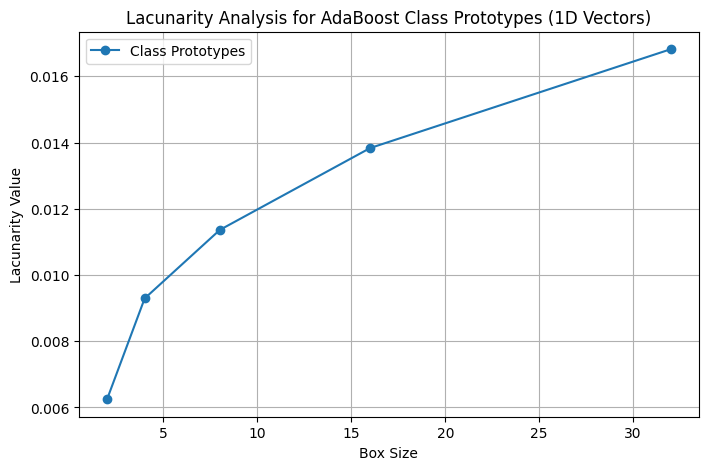

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from scipy.spatial.distance import cdist

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train AdaBoost Model (Using Decision Trees as Base Estimators)
# --------------------------------------------
adaboost_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")
start_time = time.time()
adaboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Leaf-Based Embeddings
# --------------------------------------------
X_train_embeddings = np.array([tree.apply(X_train) for tree in adaboost_classifier.estimators_]).T
X_test_embeddings = np.array([tree.apply(X_test) for tree in adaboost_classifier.estimators_]).T

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for AdaBoost Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**CAT BOOST**

In [ ]:
!pip install catboost

In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


Training CatBoost model...
0:	learn: 2.2220090	total: 11.3ms	remaining: 11.3s
50:	learn: 0.8367107	total: 483ms	remaining: 8.98s
100:	learn: 0.7054697	total: 919ms	remaining: 8.18s
150:	learn: 0.6279999	total: 1.36s	remaining: 7.67s
200:	learn: 0.5726932	total: 1.8s	remaining: 7.15s
250:	learn: 0.5297150	total: 2.24s	remaining: 6.7s
300:	learn: 0.4948440	total: 2.68s	remaining: 6.22s
350:	learn: 0.4644328	total: 3.11s	remaining: 5.75s
400:	learn: 0.4384006	total: 3.55s	remaining: 5.3s
450:	learn: 0.4154143	total: 4s	remaining: 4.87s
500:	learn: 0.3951338	total: 4.43s	remaining: 4.42s
550:	learn: 0.3739628	total: 4.88s	remaining: 3.98s
600:	learn: 0.3566610	total: 5.32s	remaining: 3.53s
650:	learn: 0.3404486	total: 5.74s	remaining: 3.08s
700:	learn: 0.3256420	total: 6.16s	remaining: 2.63s
750:	learn: 0.3117101	total: 6.58s	remaining: 2.18s
800:	learn: 0.2987862	total: 7s	remaining: 1.74s
850:	learn: 0.2857439	total: 7.44s	remaining: 1.3s
900:	learn: 0.2731399	total: 7.87s	remaining: 865

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


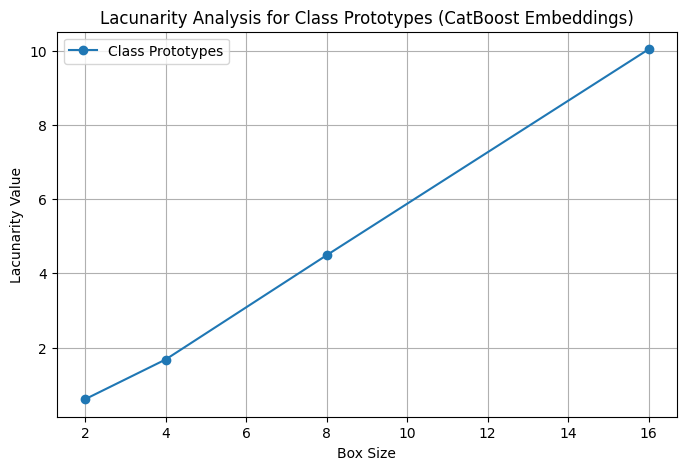

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from scipy.spatial.distance import cdist

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,          # Number of boosting iterations
    depth=6,                 # Maximum depth of trees
    learning_rate=0.1,       # Learning rate
    loss_function="MultiClass",  # Multi-class classification
    eval_metric="MultiClass",
    task_type="GPU",         # Use GPU if available
    verbose=50               # Show training progress
)

print("Training CatBoost model...")
start_time = time.time()  # Start timing
catboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Probability-Based Features for Prototypes
# --------------------------------------------
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

# --------------------------------------------
# ✅ Compute Class Prototypes (Mean Probability Vectors for Each Class)
# --------------------------------------------
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation and Lacunarity
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Reasonable box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (CatBoost Embeddings)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

# **SALINAS**

**XG BOOST**

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:15:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:15:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.06 minutes


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:15:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Computing lacunarity for box size 2...
Computing lacunarity for box size 4...
Computing lacunarity for box size 8...
Computing lacunarity for box size 16...
Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2          0.319976
1         4          0.806451
2         8          1.503192
3        16          1.670194
4        32          1.718017


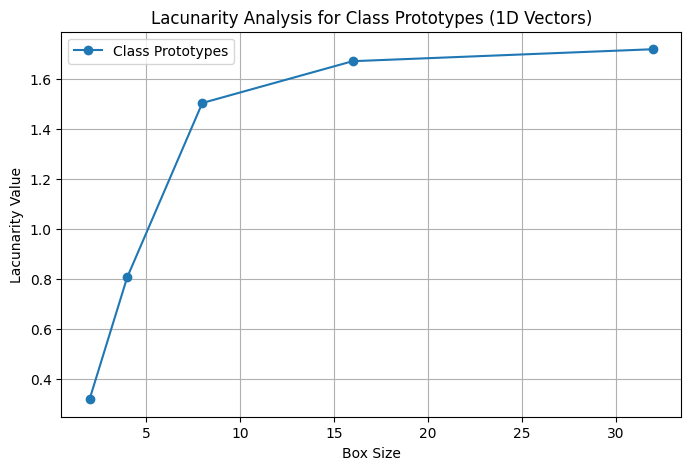

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from sklearn.decomposition import PCA

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train XGBoost Model
# --------------------------------------------
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")
start_time = time.time()
xgb_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Class Prototypes
# --------------------------------------------
X_train_embeddings = xgb_classifier.apply(X_train)

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])


# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Use reasonable box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**ADA BOOST**

Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Training Time: 1.23 minutes
Computing lacunarity for box size 2...
Computing lacunarity for box size 4...
Computing lacunarity for box size 8...
Computing lacunarity for box size 16...
Computing lacunarity for box size 32...
   Box Size  Class Prototypes
0         2          0.036895
1         4          0.057679
2         8          0.067914
3        16          0.072818
4        32          0.073856


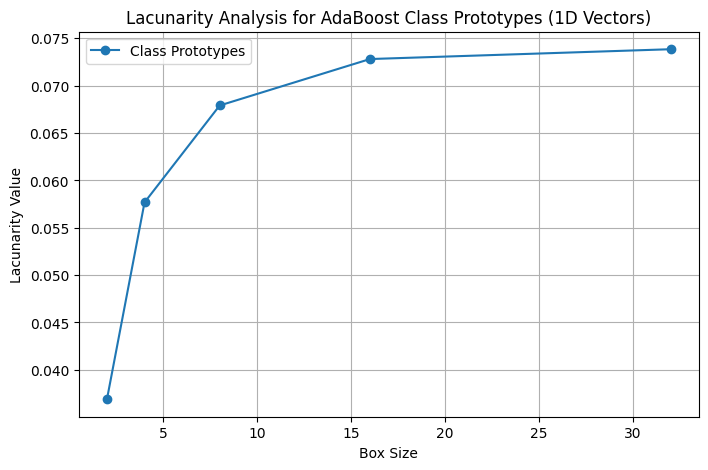

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from scipy.spatial.distance import cdist

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train AdaBoost Model (Using Decision Trees as Base Estimators)
# --------------------------------------------
adaboost_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")
start_time = time.time()
adaboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Leaf-Based Embeddings
# --------------------------------------------
X_train_embeddings = np.array([tree.apply(X_train) for tree in adaboost_classifier.estimators_]).T
X_test_embeddings = np.array([tree.apply(X_test) for tree in adaboost_classifier.estimators_]).T

# Compute Class Prototypes (Mean Embeddings for Each Class)
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for AdaBoost Class Prototypes (1D Vectors)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")

**CAT BOOST**

Training CatBoost model...
0:	learn: 2.0383107	total: 12.9ms	remaining: 12.9s
50:	learn: 0.4245617	total: 486ms	remaining: 9.04s
100:	learn: 0.3474875	total: 922ms	remaining: 8.21s
150:	learn: 0.3078338	total: 1.36s	remaining: 7.63s
200:	learn: 0.2787361	total: 1.81s	remaining: 7.2s
250:	learn: 0.2586064	total: 2.25s	remaining: 6.73s
300:	learn: 0.2430352	total: 2.68s	remaining: 6.23s
350:	learn: 0.2279850	total: 3.12s	remaining: 5.77s
400:	learn: 0.2157942	total: 3.56s	remaining: 5.31s
450:	learn: 0.2037743	total: 3.98s	remaining: 4.85s
500:	learn: 0.1926324	total: 4.42s	remaining: 4.4s
550:	learn: 0.1838309	total: 4.85s	remaining: 3.95s
600:	learn: 0.1751721	total: 5.28s	remaining: 3.51s
650:	learn: 0.1680752	total: 5.71s	remaining: 3.06s
700:	learn: 0.1608283	total: 6.13s	remaining: 2.62s
750:	learn: 0.1544673	total: 6.56s	remaining: 2.18s
800:	learn: 0.1483800	total: 6.99s	remaining: 1.74s
850:	learn: 0.1428727	total: 7.44s	remaining: 1.3s
900:	learn: 0.1377606	total: 7.87s	remaini

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


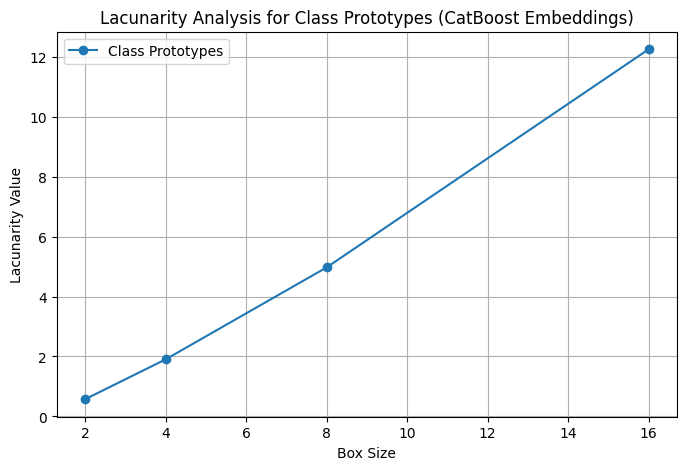

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.ndimage import generic_filter
from scipy.spatial.distance import cdist

# --------------------------------------------
# ✅ Lacunarity Calculation Function (Using ROI-Based Approach)
# --------------------------------------------
def calculate_lacunarity(features, box_size):
    """
    Compute lacunarity for 1D feature vectors using a sliding window approach.
    """
    def lacunarity_func(window):
        mean = np.mean(window)
        var = np.var(window)
        if mean == 0:
            return 0
        return var / (mean ** 2)

    # Apply sliding window for 1D features
    lacunarity_values = np.array([
        np.mean([
            lacunarity_func(features[i, j:j + box_size])
            for j in range(features.shape[1] - box_size + 1)
        ]) for i in range(features.shape[0])
    ])

    return lacunarity_values

# --------------------------------------------
# ✅ Load Spectral and Ground Truth Data
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,          # Number of boosting iterations
    depth=6,                 # Maximum depth of trees
    learning_rate=0.1,       # Learning rate
    loss_function="MultiClass",  # Multi-class classification
    eval_metric="MultiClass",
    task_type="GPU",         # Use GPU if available
    verbose=50               # Show training progress
)

print("Training CatBoost model...")
start_time = time.time()  # Start timing
catboost_classifier.fit(X_train, y_train)
training_time = (time.time() - start_time) / 60  # Convert seconds to minutes
print(f"Training Time: {training_time:.2f} minutes")

# --------------------------------------------
# ✅ Extract Probability-Based Features for Prototypes
# --------------------------------------------
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

# --------------------------------------------
# ✅ Compute Class Prototypes (Mean Probability Vectors for Each Class)
# --------------------------------------------
class_prototypes = {}
for cls in np.unique(y_train):
    class_indices = np.where(y_train == cls)[0]
    class_prototypes[cls] = X_train_embeddings[class_indices].mean(axis=0)

# Convert to NumPy Array for Distance Calculation and Lacunarity
prototype_array = np.array([class_prototypes[cls] for cls in np.unique(y_train)])

# --------------------------------------------
# ✅ Lacunarity Calculation for Class Prototypes
# --------------------------------------------
box_sizes = [2, 4, 8, 16, 32]  # Reasonable box sizes for 1D data
lacunarity_results = {"Box Size": [], "Class Prototypes": []}

for box_size in box_sizes:
    print(f"Computing lacunarity for box size {box_size}...")
    try:
        # Calculate lacunarity for class prototypes directly as 1D vectors
        lac_prototypes = np.mean(calculate_lacunarity(prototype_array, box_size))

        # Store results
        lacunarity_results["Box Size"].append(box_size)
        lacunarity_results["Class Prototypes"].append(lac_prototypes)

    except ValueError as e:
        print(f"Skipping box size {box_size} due to error: {e}")

# ✅ Create DataFrame and Print Results
lacunarity_df = pd.DataFrame(lacunarity_results)
print(lacunarity_df)

# ✅ Plot Lacunarity Results
if not lacunarity_df.empty:
    plt.figure(figsize=(8, 5))
    plt.plot(lacunarity_df["Box Size"], lacunarity_df["Class Prototypes"], marker='o', label="Class Prototypes")
    plt.xlabel("Box Size")
    plt.ylabel("Lacunarity Value")
    plt.title("Lacunarity Analysis for Class Prototypes (CatBoost Embeddings)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid lacunarity values to plot.")